In [2]:
import os
import time

import torch 
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchaudio

import matplotlib.pyplot as plt
import numpy as np

from dataPrep import MTATDataset
from model import SingleExtractor

In [3]:
device = torch.device(0)

In [88]:
styEncoder = SingleExtractor(conv_channels=128,
                             sample_rate=16000,
                             n_fft=513,
                             n_harmonic=6,
                             semitone_scale=2,
                             learn_bw='only_Q').to(device)

In [87]:
! ls checkpoints/

best_training_model_epoch0_iter0_loss4.872655391693115.pth
best_training_model_epoch0_iter1_loss4.76118803024292.pth
best_training_model_epoch0_iter3_loss4.590038299560547.pth
best_training_model_epoch1_iter0_loss4.288716793060303.pth
best_training_model_epoch1_iter3_loss4.231124401092529.pth
best_training_model_epoch1_iter7_loss3.6293859481811523.pth
best_training_model_epoch2_iter2_loss3.225583076477051.pth
best_training_model_epoch2_iter4_loss2.970581531524658.pth
best_training_model_epoch2_iter7_loss2.524953842163086.pth
best_training_model_epoch2_iter9_loss2.4895241260528564.pth
best_training_model_epoch3_iter0_loss1.9178204536437988.pth
best_training_model_epoch3_iter3_loss1.5174627304077148.pth
best_training_model_epoch3_iter6_loss0.8046345710754395.pth
best_training_model_epoch3_iter8_loss0.16112041473388672.pth
best_training_model_epoch3_iter9_loss0.0.pth


In [89]:
styEncoder.load_state_dict(torch.load('checkpoints/best_training_model_epoch3_iter9_loss0.0.pth'))

<All keys matched successfully>

In [90]:
pos_dir = '../Data/spectrogram_pos/'
neg_dir = '../Data/spectrogram_neg/'

audio_embeddings = []
audio_labels = []

for file in os.listdir(pos_dir):
    file_path = os.path.join(pos_dir, file)
    spec = np.load(file_path)
    emb = styEncoder(Variable(torch.tensor(spec).unsqueeze(0)).to(device)).cpu().detach().numpy().flatten()
    # print (emb.shape)
    audio_embeddings.append(emb)
    audio_labels.append(1)

for file in os.listdir(neg_dir):
    file_path = os.path.join(neg_dir, file)
    spec = np.load(file_path)
    emb = styEncoder(Variable(torch.tensor(spec).unsqueeze(0)).to(device)).cpu().detach().numpy().flatten()
    # print (emb.shape)
    audio_embeddings.append(emb)
    audio_labels.append(2)

In [91]:
audio_embeddings = np.array(audio_embeddings)
audio_labels = np.array(audio_labels)

In [92]:
# calculate distance matrix
def calculateCosineDistMat(data):
    num = len(data)
    dist = np.zeros((num, num))
    for i in range(num):
        for j in range(i+1):
            if i == j:
                dist[i, j] = .0
                continue
            d = np.dot(audio_embeddings[i], audio_embeddings[j])/(np.linalg.norm(audio_embeddings[i]) * np.linalg.norm(audio_embeddings[j]))
            dist[i, j] = d
            dist[j, i] = d
    return dist

def calculateEuclideanDistMat(data):
    num = len(data)
    dist = np.zeros((num, num))
    for i in range(num):
        for j in range(i+1):
            if i == j:
                dist[i, j] = .0
                continue
            d = np.linalg.norm(data[i] - data[j])
            dist[i, j] = d
            dist[j, i] = d
    return dist

# dist_mat = calculateCosineDistMat(audio_embeddings)
dist_mat = calculateEuclideanDistMat(audio_embeddings)

In [95]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric='precomputed', perplexity=50)
X_emb = tsne.fit_transform(dist_mat)

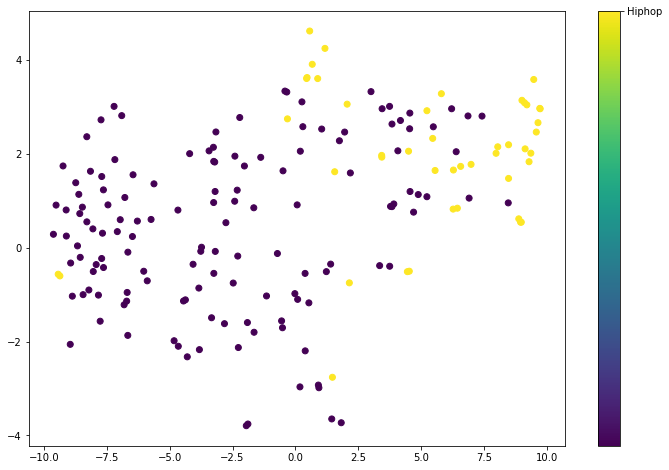

In [96]:
plt.figure(figsize=(12,8))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=audio_labels)
cb = plt.colorbar()
cb.set_ticks(np.arange(1,3))
cb.set_ticklabels(['Hiphop', 'Non-Hiphop'])